In [2]:
import requests
import pandas as pd
from tqdm import tqdm
import folium
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
url_inventory_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-inventory.txt"
url_stations_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt"
url_countries_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-countries.txt"
url_states_txt = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-states.txt"
url_state_raw = "https://raw.githubusercontent.com/georgique/world-geojson/develop/states/usa/new_hampshire.json"

In [4]:
def parse_stations_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "ID": line[0:11].strip(),
                "LATITUDE": float(line[12:20].strip()),
                "LONGITUDE": float(line[21:30].strip()),
                "ELEVATION": float(line[31:37].strip()),
                "STATE": line[38:40].strip(),
                "NAME": line[38:68].strip(),
            })
    return pd.DataFrame(data)

def parse_inventory_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "ID": line[0:11].strip(),
                "LATITUDE": float(line[12:20].strip()),
                "LONGITUDE": float(line[21:30].strip()),
                "ELEMENT": line[31:35].strip(),
                "FIRSTYEAR": int(line[36:40].strip()),
                "LASTYEAR": int(line[41:45].strip())
            })
    return pd.DataFrame(data)

def parse_countries_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "CODE": line[0:2].strip(),
                "NAME": line[3:64].strip()
            })
    return pd.DataFrame(data)

def parse_states_txt(url):
    r = requests.get(url)
    lines = r.text.split("\n")
    data = []
    for line in lines:
        if line:
            data.append({
                "CODE": line[0:2].strip(),
                "NAME": line[3:50].strip()
            })
    return pd.DataFrame(data)

def parse_data_dly(line):
    data = []
    for i in range(21, 269, 8):
        value = int(line[i:i+5])
        mflag = line[i+5]
        qflag = line[i+6]
        sflag = line[i+7]
        data.extend([value, mflag, qflag, sflag])
    return {
        "ID": line[0:11].strip(),
        "YEAR": int(line[11:15]),
        "Month": int(line[15:17]),
        "ELEMENT": line[17:21].strip(),
        "DATA": data
    }

def read_data_from_url(url):
    data = []
    response = requests.get(url)
    if response.status_code == 200:
        for line in response.text.splitlines():
            data.append(parse_data_dly(line))
    else:
        print(f"Failed to retrieve data for {url}. Status code: {response.status_code}")
    return data

def fetch_and_save_to_dataframe(station_ids):
    all_data = []
    for station_id in tqdm(station_ids, desc="Fetching Data", unit="station", ncols=100):
        url = f"https://www.ncei.noaa.gov/pub/data/ghcn/daily/all/{station_id}.dly"
        data = read_data_from_url(url)
        all_data.extend(data)
    headers = ["ID", "YEAR", "Month", "ELEMENT"]
    for i in range(1, 32):
        headers.extend([f"VALUE{i}", f"MFLAG{i}", f"QFLAG{i}", f"SFLAG{i}"])
    df_data = []
    for entry in all_data:
        row = [entry["ID"], entry["YEAR"], entry["Month"], entry["ELEMENT"]]
        row.extend(entry["DATA"])
        df_data.append(row)
    return pd.DataFrame(df_data, columns=headers)


In [5]:
inventory = parse_inventory_txt(url_inventory_txt)
stations= parse_stations_txt(url_stations_txt)
countries = parse_countries_txt(url_countries_txt)
states = parse_states_txt(url_states_txt)

In [6]:
s_state_list=stations[stations['STATE']=='NH']['ID'].tolist()
s_live_list=inventory[(inventory['ID'].isin(s_state_list)) & (inventory['LASTYEAR']>2024)]['ID'].unique().tolist()

In [7]:
data= fetch_and_save_to_dataframe(s_live_list)

Fetching Data: 100%|█████████████████████████████████████████| 148/148 [00:27<00:00,  5.36station/s]


In [8]:
flag_columns = [col for col in data.columns if 'FLAG' in col]
data= data.drop(columns=flag_columns)
data.replace(-9999.0, np.nan, inplace=True)
weather_variables = ['TMAX', 'TMIN', 'SNOW', 'SNWD', 'PRCP']
data=data[data['ELEMENT'].isin(weather_variables)]

In [9]:
def find_missing_months_for_station(data, station):
    station_data = data[data['ID'] == station].copy()
    station_data['YEAR_MONTH'] = station_data['YEAR'].astype(str) + '-' + station_data['Month'].astype(str).str.zfill(2)
    start_year = station_data['YEAR'].min()
    end_year = station_data['YEAR'].max()
    first_available_month = station_data[station_data['YEAR'] == start_year]['Month'].min()
    start_year_month = f"{start_year}-{str(first_available_month).zfill(2)}"
    last_available_month = station_data[station_data['YEAR'] == end_year]['Month'].max()
    available_year_month_pairs = set(station_data['YEAR_MONTH'])
    
    full_year_month_pairs = set(
        [f"{year}-{str(month).zfill(2)}" for year in range(start_year, end_year) for month in range(1, 13)]
    )
    
    missing_pairs = full_year_month_pairs - available_year_month_pairs
    missing_years = {}
    for pair in missing_pairs:
        year, month = pair.split('-')
        year = int(year)
        month = int(month)
        if year == start_year and month < first_available_month:
            continue
        if year not in missing_years:
            missing_years[year] = []
        missing_years[year].append(str(month).zfill(2))
    
    return missing_years, start_year_month, end_year, last_available_month, start_year, end_year

stations_list = data['ID'].unique()
stations_without_missing_data = []
for station in stations_list:
    missing_years, start_year_month, end_year, last_available_month, start_year, end_year = find_missing_months_for_station(data, station)
    if not missing_years:
        duration = end_year - start_year + 1
        stations_without_missing_data.append((station, duration))


In [10]:
stations_without_missing_data = pd.DataFrame(stations_without_missing_data, columns=['ID', 'Duration'])
stations_without_missing_data=stations_without_missing_data[stations_without_missing_data['Duration']>=10]
stations_without_missing_data=stations_without_missing_data['ID'].tolist()
print(f"Number of stations with at least 15 years of data for all months: {len(stations_without_missing_data)}")

Number of stations with at least 15 years of data for all months: 45


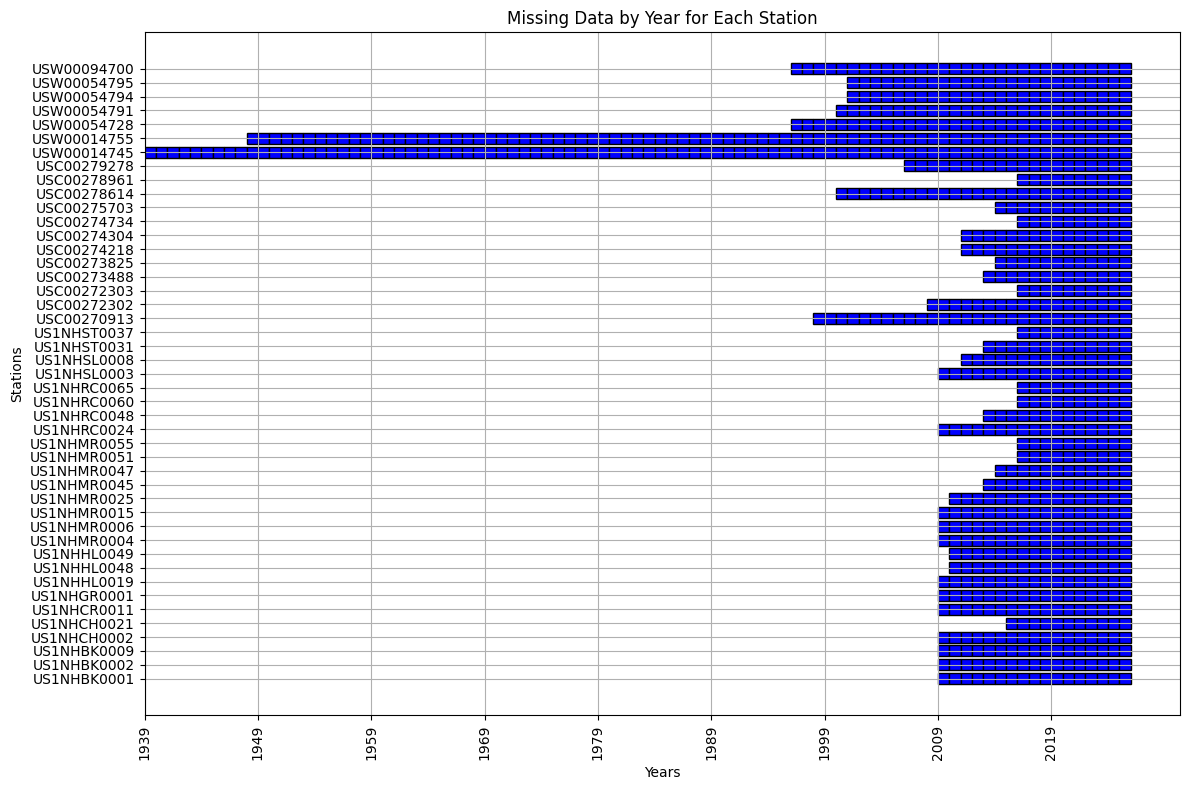

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
missing_color = 'red'
available_color = 'blue'
min_overall_year = min([data[data['ID'] == station]['YEAR'].min() for station in stations_without_missing_data])
max_overall_year = max([data[data['ID'] == station]['YEAR'].max() for station in stations_without_missing_data])

# Create the missing_by_station dictionary
missing_by_station = {}
for station in stations_without_missing_data:
    missing_years, _, _, _, _, _ = find_missing_months_for_station(data, station)
    missing_by_station[station] = missing_years

for idx, station in enumerate(stations_without_missing_data):
    min_year = data[data['ID'] == station]['YEAR'].min()
    max_year = data[data['ID'] == station]['YEAR'].max()
    if min_year == max_year:
        continue
    if min_year < max_year:
        years = np.arange(min_year, max_year + 1)
        availability_matrix = np.zeros(len(years))
        for year in missing_by_station.get(station, {}).keys():
            year_indices = np.where(years == year)
            if year_indices[0].size > 0:
                year_idx = year_indices[0][0]
                availability_matrix[year_idx] = 1 
        for i, year in enumerate(years):
            if availability_matrix[i] == 1:
                ax.barh(idx, 1, left=year, height=0.8, color=missing_color, edgecolor='black')
            else:
                ax.barh(idx, 1, left=year, height=0.8, color=available_color, edgecolor='black')
ax.set_xlabel('Years')
ax.set_ylabel('Stations')
ax.set_title('Missing Data by Year for Each Station')
x_ticks = [min_overall_year] + list(range(min_overall_year + 10, max_overall_year, 10)) 
ax.set_xticks(x_ticks)
ax.set_yticks(np.arange(len(stations_without_missing_data)))
ax.set_yticklabels(stations_without_missing_data)
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
data = data[data['ID'].isin(stations_without_missing_data)]

In [13]:
state_stations = stations[stations['STATE']=='NH']
state_lat = state_stations['LATITUDE'].mean()
state_lon = state_stations['LONGITUDE'].mean()
state_map = folium.Map(location=[state_lat, state_lon], 
                       zoom_start=7.5,
                       min_zoom=6,
                       max_zoom=10)

stations_to_plot = stations[stations['ID'].isin(stations_without_missing_data)]
for _, row in stations_to_plot.iterrows():
    folium.Marker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        popup=row['NAME'],
        tooltip=row['NAME']
    ).add_to(state_map)
try:
    geojson_data = requests.get(url_state_raw).json() 
    folium.GeoJson(geojson_data, name="State Boundary").add_to(state_map)
except Exception as e:
    print(f"Error loading GeoJSON: {e}")
    
state_map

In [14]:
import os
def extract_and_save_variable_dataframes(df, variables, output_dir='Data/Variable_Data'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    dataframes = {}
    for var in variables:
        var_df = df[df['ELEMENT'] == var].copy()
        dataframes[var] = var_df
        var_df.to_csv(f'{output_dir}/{var}_data.csv', index=False)
        
    return dataframes
def transform_to_daily_data(df, element):
    transformed_data = []
    for _, row in df.iterrows():
        station_id = row['ID']
        year = row['YEAR']
        month = row['Month']
        for day in range(1, 32):
            date_str = f"{year}-{month:02d}-{day:02d}"
            value_column = f'VALUE{day}'
            element_value = row.get(value_column, None)
            if pd.notna(element_value):
                transformed_data.append({
                    'DATE': date_str,
                    'ID': station_id,
                    element: element_value
                })
    transformed_df = pd.DataFrame(transformed_data)
    return transformed_df

def transform_all_variables_to_daily_data(variable_dfs, output_dir='Data/Transform_Data'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for var, df in variable_dfs.items():
        transformed_df = transform_to_daily_data(df, var)
        transformed_df.to_csv(f'{output_dir}/{var}_data.csv', index=False)
variable_dfs = extract_and_save_variable_dataframes(data, weather_variables)
transform_all_variables_to_daily_data(variable_dfs)

In [15]:
import glob
def combine_csv_files(directory_path: str) -> pd.DataFrame:
    csv_files = glob.glob(f'{directory_path}/*_data.csv')
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in the directory: {directory_path}")
    combined_df = pd.read_csv(csv_files[0])
    for file in csv_files[1:]:
        df = pd.read_csv(file)
        df = df.rename(columns=lambda x: x.split('_')[0] if '_' in x else x)
        combined_df = pd.merge(combined_df, df, on=['ID', 'DATE'], how='outer', suffixes=('_left', '_right'))
    return combined_df
combined_df = combine_csv_files('Data/Transform_Data')

In [16]:
def add_season_column(df):
    df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
    def get_season(month):
        if month in [12, 1, 2]:  # Winter: Dec, Jan, Feb
            return 'Winter'
        elif month in [3, 4, 5]:  # Spring: Mar, Apr, May
            return 'Spring'
        elif month in [6, 7, 8]:  # Summer: Jun, Jul, Aug
            return 'Summer'
        else:  # Fall: Sep, Oct, Nov
            return 'Fall'
    df['Season'] = df['DATE'].dt.month.apply(get_season)
    return df

combined_df = add_season_column(combined_df)
print(combined_df.head())

        DATE           ID  SNWD  SNOW  TMIN  TMAX   PRCP  Season
0 2009-06-19  US1NHBK0001   NaN   NaN   NaN   NaN  249.0  Summer
1 2009-06-20  US1NHBK0001   NaN   NaN   NaN   NaN   46.0  Summer
2 2009-06-21  US1NHBK0001   NaN   NaN   NaN   NaN    0.0  Summer
3 2009-06-22  US1NHBK0001   NaN   NaN   NaN   NaN   18.0  Summer
4 2009-06-23  US1NHBK0001   NaN   NaN   NaN   NaN   10.0  Summer


In [17]:
def process_columns(df, columns_to_divide):
    for col in columns_to_divide:
        df[col] = pd.to_numeric(df[col], errors='coerce')  
    for col in columns_to_divide:
        if col == 'SNOW':
            df.rename(columns={col: f"{col}"}, inplace=True)
        else:
            df[col] = df[col] / 10  
            df.rename(columns={col: f"{col}"}, inplace=True)
    
    return df
columns_to_divide = ['TMIN', 'TMAX', 'PRCP','SNOW','SNWD']
combined_df = process_columns(combined_df, columns_to_divide)

In [18]:
df_combined = pd.merge(combined_df, stations, on='ID', how='left')
df_combined = df_combined[['DATE','ID', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'Season', 'TMIN', 'TMAX', 'PRCP', 'SNOW', 'SNWD']]

In [19]:
df_combined.groupby(['ID', 'Season'])[['TMIN', 'TMAX', 'SNOW', 'SNWD', 'PRCP']].agg(lambda x: x.isnull().sum()).to_csv('Data/Summary.csv')

In [ ]:
summary_df=pd.read_csv('Data/Summary.csv')
summary_df = summary_df[~summary_df[['TMIN', 'TMAX', 'SNOW', 'SNWD', 'PRCP']].gt(500).any(axis=1)]
stations_with_low_values = summary_df['ID'].unique().tolist()
print(f"Stations where none of the columns has a value greater than 500: {len(stations_with_low_values)}")

Stations where none of the columns has a value greater than 500:10


In [21]:
df_combined[df_combined['ID'].isin(stations_with_low_values)].groupby(['ID', 'Season'])[['TMIN', 'TMAX', 'SNOW', 'SNWD', 'PRCP']].agg(lambda x: x.isnull().sum())

TMIN  TMAX  SNOW  SNWD  PRCP
ID          Season                              
USC00272302 Fall       0     0     0     0     0
            Spring    10     9     0     0     2
            Summer    11    10     1     1     0
            Winter     7     7     1     0     0
USC00272303 Fall       1     1     0     0     3
            Spring     1     1     0     0     1
            Summer     4     4     0     0     8
            Winter     0     0     0     0     0
USC00273825 Fall     195   197     0     1   154
            Spring   169   171     4    41   133
            Summer   148   149     7     0   201
            Winter   139   141     8    77   141
USC00274218 Fall      51    51   214   227    57
            Spring    27    23   421   485    37
            Summer    27    25   178   178    19
            Winter    12    17   369   578    67
USC00274304 Fall       8     7    82    83     8
            Spring     1     1    37    36     1
            Summer     2     1    92   123     0
            Winter     0     0   104    60     2
USC00275703 Fall       0     0     0     0     0
            Spring     0     0     0     3     0
            Summer     0     0     0     0     0
            Winter     0     0     0     2     0
USC00278614 Fall       2     4     0     2     6
            Spring     1     1     1     1     0
            Summer     2     1     1     1     4
            Winter     0     0     0     1     1
USC00279278 Fall       0     0     0     0     0
            Spring     0     0     0     0     0
            Summer     0     0     0     0     0
            Winter    31    31     0     0     0
USW00014745 Fall       2     0   146   813    57
            Spring     0     0   211   602    31
            Summer     3     2   184  1013    55
            Winter     0     0   182   281    47
USW00014755 Fall       0     0     0     1     0
            Spring     0     0     1     2     0
            Summer     0     0     0     0     0
            Winter     0     0     0     0     0

In [22]:
df_combined=df_combined[df_combined['ID'].isin(stations_with_low_values)]
df_combined.to_csv('Data/Final.csv', index=False)

In [24]:
df=pd.read_csv('Data/Final.csv')

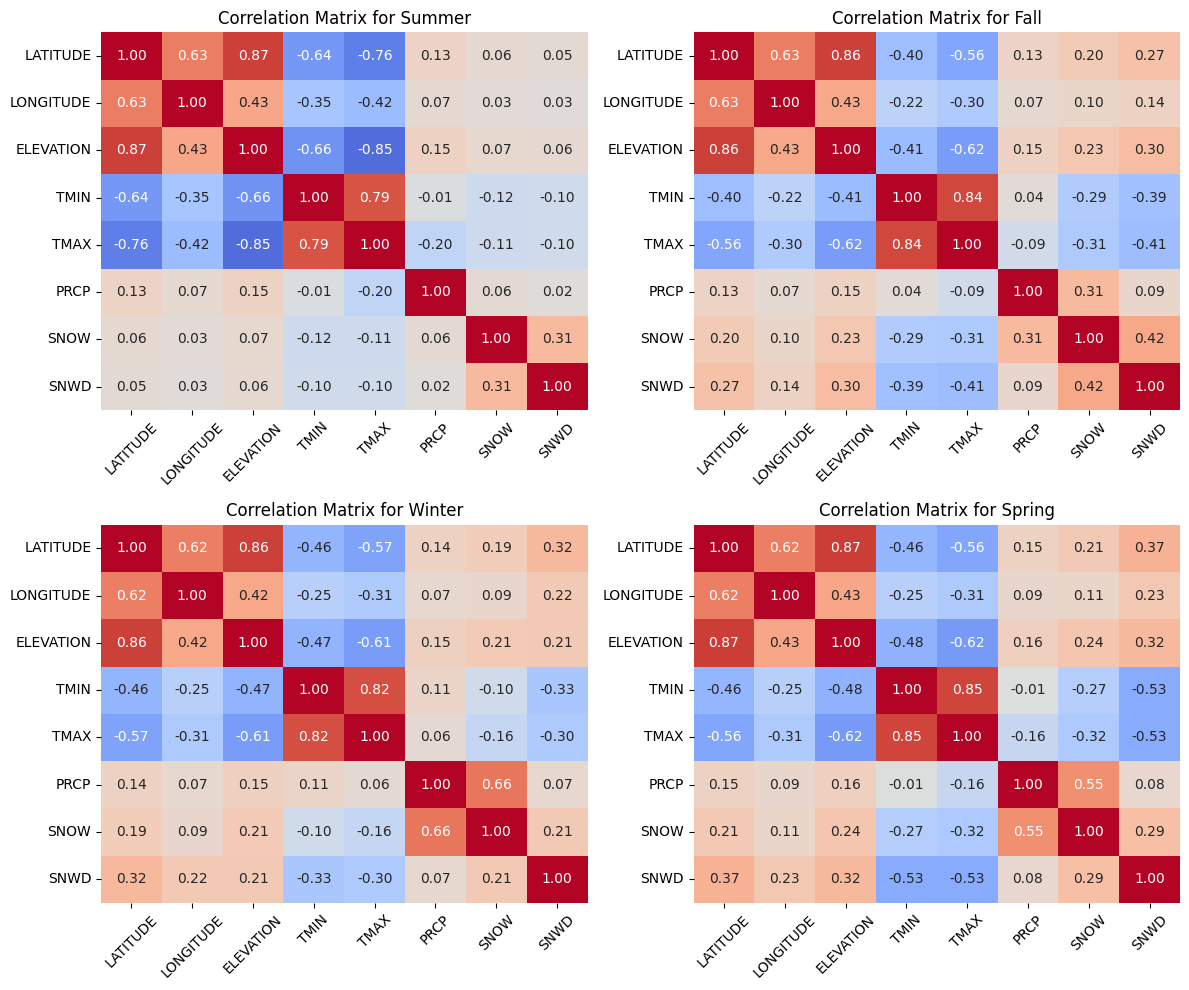

In [ ]:
def correlation_by_season(df):
    seasons = df['Season'].unique()
    correlation_matrices = {}
    
    for season in seasons:
        season_df = df[df['Season'] == season]
        numerical_columns = season_df.select_dtypes(include='number')
        correlation_matrix = numerical_columns.corr()
        correlation_matrices[season] = correlation_matrix
    
    return correlation_matrices
correlation_matrices = correlation_by_season(df)

def plot_seasonal_correlations_in_quadrants(correlation_matrices):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    for i, (season, corr_matrix) in enumerate(correlation_matrices.items()):
        row = i // 2 
        col = i % 2   
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, 
                    ax=axes[row, col], cbar=False, fmt='.2f')
        
        axes[row, col].set_title(f'Correlation Matrix for {season}')
        axes[row, col].tick_params(axis='x', rotation=45) 
        axes[row, col].tick_params(axis='y', rotation=0)   
    plt.tight_layout()
    plt.show()
plot_seasonal_correlations_in_quadrants(correlation_matrices)

In [26]:
season_station_desc = df.groupby(['ID','Season']).describe().round(2)
attributes = ['TMIN', 'TMAX', 'PRCP', 'SNOW', 'SNWD']
for attribute in attributes:
    print(f"Descriptive Statistics for {attribute}:")
    print(season_station_desc[attribute])
    print("\n" + "="*50 + "\n") 


Descriptive Statistics for TMIN:
                     count   mean   std   min   25%    50%   75%   max
ID          Season                                                    
USC00272302 Fall    1547.0   4.27  6.73 -13.9  -1.1   3.90   9.4  20.6
            Spring  1465.0   1.89  6.75 -20.0  -2.2   1.70   6.7  20.6
            Summer  1523.0  14.59  3.58   2.2  11.7  14.40  17.2  24.4
            Winter  1526.0  -8.06  6.04 -26.7 -11.7  -7.20  -3.3   9.4
USC00272303 Fall     814.0   3.57  6.82 -17.8  -1.7   3.90   8.9  18.9
            Spring   735.0  -0.28  6.81 -22.8  -3.9   0.00   4.4  18.9
            Summer   821.0  12.87  3.84   0.6  10.0  12.80  15.6  22.8
            Winter   812.0  -9.49  6.63 -28.3 -13.9  -8.90  -3.9   3.9
USC00273825 Fall     614.0   3.40  6.62 -17.2  -2.2   3.30   8.3  19.4
            Spring   572.0   0.08  6.70 -23.3  -3.3   0.60   4.4  17.2
            Summer   643.0  12.69  3.96   0.0  10.0  12.80  15.6  22.8
            Winter   568.0  -9.49  6.48 -27.